# Ibovespa forecasting using neural networks

## Machine Learning Engineer Nanodegree - Capstone Proposal

### Import python packages

In [1]:
import os
import pandas as pd

from torch.nn import L1Loss
from torch.optim import Adam

from ibov.utils import load_config
from ibov.model import train, torch_data, model_fc1h, model_fc2h, model_lstm, Model
from ibov.feature import create_lags, consolidate_features, create_delta_sign, label_train_test, Normalize
from ibov.request import get_history
from ibov.metrics import calculate_metrics, model_prediction, benchmark_model, graphical_evaluation

### Loading Configs

In [2]:
# Load config dict
config = load_config()

In [3]:
# Feature Engineering Configs
window = config.get("feature").get("window")
variables = config.get("feature").get("variables")
test_split = config.get("feature").get("split").get("test")
valid_split = config.get("feature").get("split").get("valid")

# Data Configs
data_dir = config.get("data").get("dir")
ibov_ticker = config.get("ibov").get("ticker")
filename = config.get("data").get("file")
data_size = config.get("data").get("size")
ascending = config.get("data").get("ascending") == 'True'

# Model configurations
dropout = config.get("model").get("dropout")
hidden_layer = config.get("model").get("hidden_layer")
lr = config.get("model").get("lr")
seed = config.get("model").get("seed")
epochs = config.get("model").get("epochs")

### Data Preparation

In [4]:
# Invoke yahoo finance api
#ibovespa = get_history(ticker=ibov_ticker, data_size=data_size, ascending=ascending)

# Save data on disk
#ibovespa.to_csv(os.path.join(data_dir, filename), index=False)

# Read from disk
ibovespa = pd.read_csv(os.path.join(data_dir, filename))

# Label datapoint as train or test dataset
ibovespa = label_train_test(ibovespa, split=test_split, split_valid=valid_split, ascending=ascending)

### Feature Engineering

In [5]:
scaler = Normalize()
scaler.fit(ibovespa[ibovespa["group"]=="train"][["close"]])
ibovespa[["close"]] = scaler.transform(ibovespa[["close"]])

In [6]:
# Create lag variables
ibov_lags_df = create_lags(ibovespa, window=window, var="close", index="date")

In [7]:
# Create sign variables
ibov_delta_sign_df = create_delta_sign(ibov_lags_df, var="lags", index="date", window=window)

In [8]:
# Consolidate raw data with features
master_table = consolidate_features(ibovespa, "date", ibov_lags_df, ibov_delta_sign_df)

In [9]:
# Load data to torch standard
train_loader, train_x_tensor, train_y_tensor = \
    torch_data(master_table, target="target", variables=variables, group_var="group", batch=50, group="train")

valid_loader, valid_x_tensor, valid_y_tensor = \
    torch_data(master_table, target="target", variables=variables, group_var="group", batch=50, group="valid")

test_loader, test_x_tensor, test_y_tensor = \
    torch_data(master_table, target="target", variables=variables, group_var="group", batch=50, group="test")

### Training step

In [10]:
from torch import nn
import torch

In [11]:
class Model(nn.Module):

    def __init__(self, input_layer, hidden_layer=50, dropout=0.25):

        super(Model, self).__init__()
        self.hidden_layer = hidden_layer
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(input_layer, hidden_layer)
        self.fc2 = nn.Linear(hidden_layer+hidden_layer, 1)

        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer),
                            torch.zeros(1,1,self.hidden_layer))
        
        self.lstm = nn.LSTM(input_layer, hidden_layer)
        
    def forward(self, input):

        x = input[:,0,:]
        z = input[:,1,:]
        x = self.fc1(x)
        x = self.dropout(x)

        lstm_out, self.hidden_cell = self.lstm(z.view(len(z),1 , -1), self.hidden_cell)
        ds = torch.cat((x,lstm_out[:,0,:]),1)
        output = self.fc2(ds)

        return output

In [12]:
# Model definition
model = Model(input_layer=window, hidden_layer=hidden_layer, dropout=dropout)
criterion = L1Loss()
optimizer = Adam(model.parameters(), lr=lr)

In [13]:
# Model training
train(model, train_loader, valid_loader, criterion, optimizer, epochs=epochs, seed=seed)

18:45:56, epoch: 0, train: 3.331, valid: 0.399
18:45:56, epoch: 1, train: 1.859, valid: 0.126
18:45:57, epoch: 2, train: 0.836, valid: 0.128
18:45:58, epoch: 3, train: 0.93, valid: 0.136
18:45:59, epoch: 4, train: 0.746, valid: 0.037
18:46:00, epoch: 5, train: 0.602, valid: 0.058
18:46:01, epoch: 6, train: 0.623, valid: 0.051
18:46:03, epoch: 7, train: 0.598, valid: 0.032
18:46:05, epoch: 8, train: 0.585, valid: 0.033
18:46:07, epoch: 9, train: 0.554, valid: 0.033
18:46:09, epoch: 10, train: 0.541, valid: 0.034
18:46:11, epoch: 11, train: 0.565, valid: 0.038
18:46:14, epoch: 12, train: 0.572, valid: 0.034
18:46:17, epoch: 13, train: 0.511, valid: 0.031
18:46:20, epoch: 14, train: 0.529, valid: 0.029
18:46:23, epoch: 15, train: 0.501, valid: 0.03
18:46:27, epoch: 16, train: 0.484, valid: 0.032
18:46:31, epoch: 17, train: 0.482, valid: 0.033
18:46:35, epoch: 18, train: 0.544, valid: 0.029
18:46:39, epoch: 19, train: 0.491, valid: 0.031
18:46:44, epoch: 20, train: 0.489, valid: 0.031
18:4

### Evaluation

In [14]:
# Model performance on Training dataset
train_true, train_pred = model_prediction(model, train_x_tensor, train_y_tensor)
calculate_metrics(train_true, train_pred)

(0.03021354085370286, 0.7226277372262774)

In [15]:
# Model performance on Validation dataset
valid_true, valid_pred = model_prediction(model, valid_x_tensor, valid_y_tensor)
calculate_metrics(valid_true, valid_pred) 

(0.02489146026405128, 0.6923076923076923)

In [16]:
# Model performance on Test dataset
test_true, test_pred = model_prediction(model, test_x_tensor, test_y_tensor)
calculate_metrics(test_true, test_pred)

(0.01843645243809141, 0.631578947368421)

### Benchmark Model

In [17]:
# Set and Evaludate Benchmark Model
bmk_true, bmk_pred = benchmark_model(test_y_tensor, valid_y_tensor)
calculate_metrics(bmk_true, bmk_pred)

(0.019735856302853287, 0.4000000000000001)

### Graphical Evaluation

#### Test dataset and benchmark model

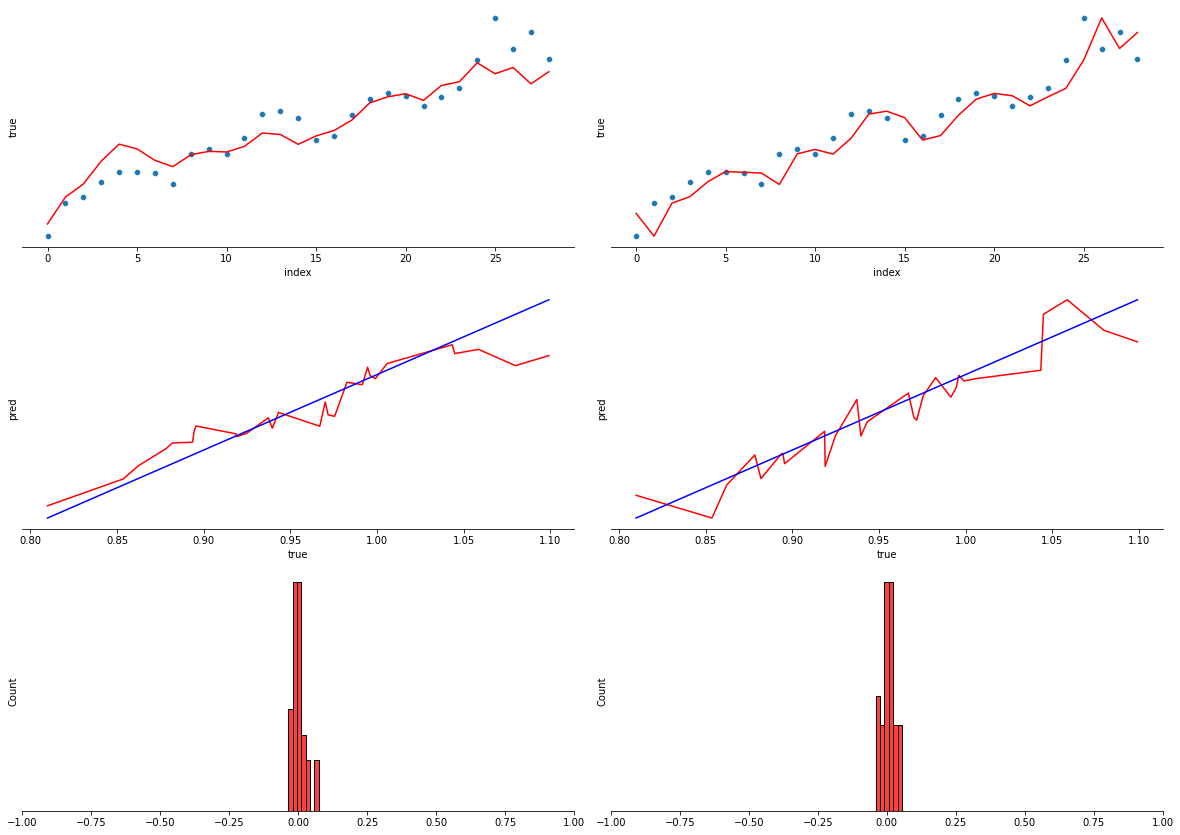

In [18]:
# Evaluate test dataset graphically
graphical_evaluation(test_true, test_pred, bmk_true, bmk_pred)

#### Train and validation datasets

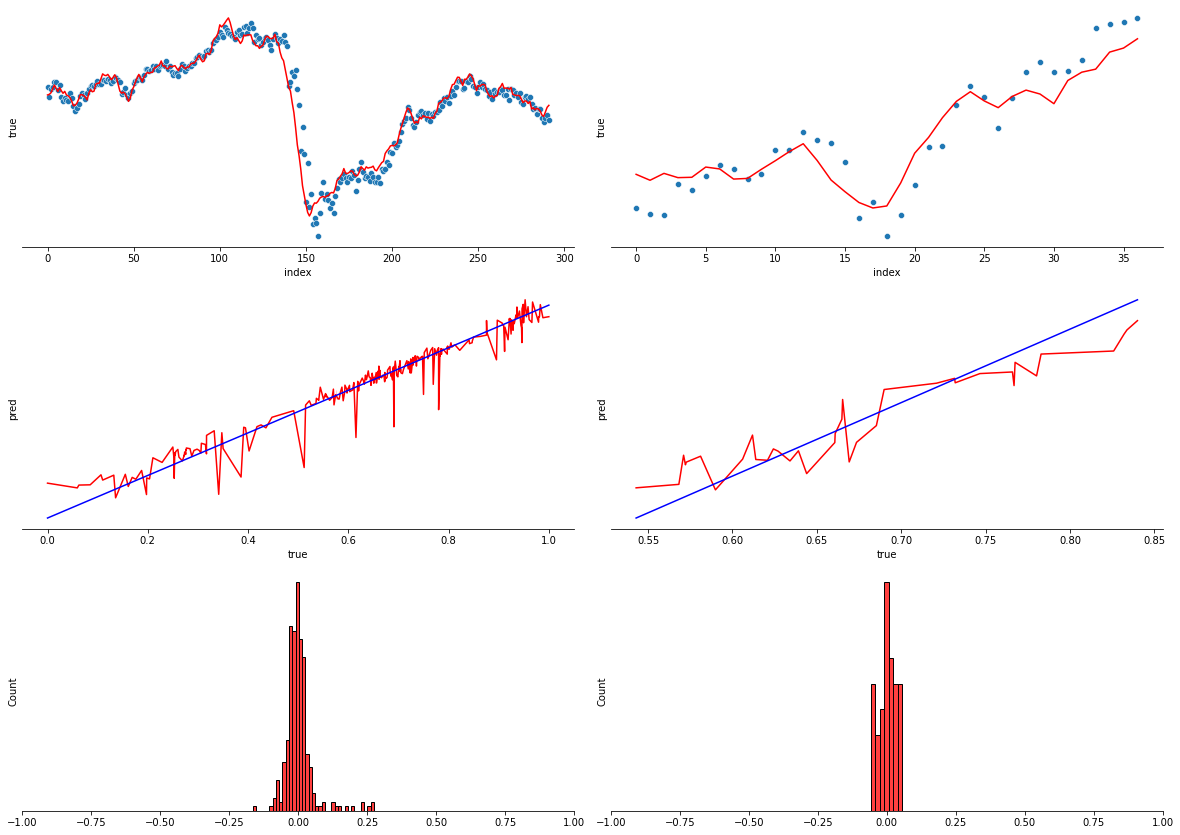

In [19]:
# Evaluate train and validation dataset graphically
graphical_evaluation(train_true, train_pred, valid_true, valid_pred)